In [1]:
import pandas as pd
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as ts
from statsmodels.graphics.tsaplots import plot_acf
from johansen import Johansen
import itertools

import datetime as dt

#%matplotlib inline
#plt.style.use('ggplot')

In [2]:
min_perday=1380

# Data

In [34]:
#df = pd.read_hdf('All.h5','table')

In [5]:
import os
os.chdir('C:\\Users\\lin\\OneDrive\\practium\\23_hour')

In [29]:
assets

['UBU8', 'ZBU8', 'TNU8', 'ZNU8', 'ZFU8', 'ZTU8']

In [33]:
#               UTB,       TB,        U10y,      10y,       5y,        2y
bonds =        ['UB',      'ZB',      'TN',       'ZN',     'ZF',      'ZT']
tick_sizes =   [0.03125,   0.03125,   0.015625,   0.015625, 0.0078125, 0.0078125]
point_values = [1000,      1000,      1000,       1000,     1000,      2000]
maturities = ['8U']
maturities_ss = ['U8'] # strategy_studio convention
file_suffix = '.pik'
series_suffix = '_mid'
contract_srt = '2018-06-01'
contract_end = '2018-09-01'
#this refer to real time point value of each asset, with respect to point value*price*weights
assets_point=[]
for i in assets:
    assets_point.append(i+'point')

#dont forget set up file path lul


#data_path = '../Data/'+str(mins_per_day)+'/'
#data_path = '../Data/'

assets = [''.join(x) for x in itertools.product(bonds,maturities)]

dfs = []
for a in assets:
    dfs.append(pd.read_pickle(a+file_suffix)[a+series_suffix])
df = pd.concat(dfs, axis=1)

# match different periods
df = df.dropna()
    
# ignore the first and last few days
#df = df.iloc[390*start_ignore:-390*end_engore]
    
# ignore the beginning and end of contract
df['shifted_trading_time'] = df.index.tz_convert('Etc/GMT-2')
df = df[(df['shifted_trading_time'] >= contract_srt) & (df['shifted_trading_time'] < contract_end)]

# drop weekends
df = df.loc[df['shifted_trading_time'].dt.weekday<5]   
df = df.drop('shifted_trading_time',axis=1)

#** for strategy studio
assets = [''.join(x) for x in itertools.product(bonds,maturities_ss)]

# name columns
df.columns = assets

In [14]:
train_template = df.copy()
train_template = train_template*point_values
weights = train_template.columns+'_weight'
for w in weights:
    train_template[w] = np.nan
train_template['trading_idx'] = np.nan
train_template['portfolio'] = np.nan
train_template['mu'] = np.nan
train_template['sigma'] = np.nan

In [15]:
len(train_template)/min_perday

66.0

In [17]:
#df.iloc[130*1380]

# Parameter

In [18]:
#change our value here!
use_optimized_parameters = True
op_fitting_days = 130+20
op_exit_threshold = 0.0
op_increment = 0.0
op_trading_days = 1

### add my rebalance part here, idk whether or not it is required lul
### I changed the part apply strategy

In [46]:
#leave this part fixed
def fit(data):
    x = data.values
    x_centered = x - np.mean(x, axis=0)
    johansen = Johansen(x_centered, model=2, significance_level=0)
    eigenvectors, r = johansen.johansen()
    #print('rejected r values are: {}'.format(r))
    vec = eigenvectors[:, 0]
    vec_max = np.max(np.abs(vec))
    vec = vec / vec_max
    #print('The first cointegrating relation: {}'.format(vec))
    return vec    


def apply_strategy(train):
    
    # get thresholds
    round_trip_cost = (np.array(tick_sizes)*np.array(point_values)*abs(train[weights])).sum(axis=1)
    min_increment = round_trip_cost/train['sigma']
    entry_threshold = exit_threshold+min_increment+increment
    train['entry_threshold'] = entry_threshold
    
    train['position'] = np.nan
    train['l_position'] = np.nan
    train['s_position'] = np.nan

    # record position changes
    train['s_position'].loc[train['portfolio'] > (train['mu'] + entry_threshold*train['sigma'])] = -1
    train['s_position'].loc[train['portfolio'] < (train['mu'] + exit_threshold*train['sigma'])] = 0

    train['l_position'].loc[train['portfolio'] < (train['mu'] - entry_threshold*train['sigma'])] = 1
    train['l_position'].loc[train['portfolio'] > (train['mu'] - exit_threshold*train['sigma'])] = 0


    # portfolio is flat at beginning of test period
    train['s_position'].iloc[0] = 0
    train['l_position'].iloc[0] = 0
    # flatten portfolio at end of each trading period
    #train['s_position'].loc[train.trading_idx.diff(-1) != 0] = 0
    #train['l_position'].loc[train.trading_idx.diff(-1) != 0] = 0
    # flatten portfolio at end
    train['s_position'].iloc[-1] = 0
    train['l_position'].iloc[-1] = 0
    # forward fill positions
    train['s_position'] = train['s_position'].ffill()
    train['l_position'] = train['l_position'].ffill()

    # sum positions
    train['position'] = train['l_position'] + train['s_position']

    # extract trades
    train['trade'] = train['position'].diff(1)
      #try to figure out what if we rebalance
    #rather than just simply force closing
    train['isrebalance_temp']=np.zeros(len(train))
    train['isrebalance_temp'].loc[train.trading_idx.diff(-1) != 0]=1
    train['isrebalance']=train['position'].values*train['isrebalance_temp'].values
    for i in assets:
        train[assets_point]=train[assets]*train[weights]*point_values
    train['rebalance']=train['position'].diff(1)

    # extract trades

    return train

  

def calc_pnl(round_trips):
    pnls = round_trips[assets]
    # adjust price changes for trade signal
    pnls = pnls.multiply(np.sign(round_trips[weights].values), axis=0)
    pnls = pnls.multiply(-np.sign(round_trips['position'].values), axis=0)
    # account for crossing the spread
    pnls = pnls - np.array(tick_sizes)*np.array(point_values)
    # apply contract weights
    pnls = pnls * np.abs(round_trips[weights].values)
    return pnls

In [39]:
def 

Index(['UBU8_weight', 'ZBU8_weight', 'TNU8_weight', 'ZNU8_weight',
       'ZFU8_weight', 'ZTU8_weight'],
      dtype='object')

In [40]:
assets

['UBU8', 'ZBU8', 'TNU8', 'ZNU8', 'ZFU8', 'ZTU8']

In [4]:
np.ones(5)*np.zeros(5)

array([0., 0., 0., 0., 0.])

In [18]:
tempa

array([[100.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.]])

In [12]:
tempb=np.ones(shape=(3,5))

In [13]:
tempb

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [23]:
tempc=np.array([1,2,3,4,5])

In [24]:
tempa*tempc

array([[100.,   2.,   3.,   4.,   5.],
       [  1.,   2.,   3.,   4.,   5.],
       [  1.,   2.,   3.,   4.,   5.]])

In [22]:
# set parameters:
if use_optimized_parameters:
    fitting_days_range = [op_fitting_days]
    exit_threshold_range = [op_exit_threshold]
    increment_range = [op_increment]
else:
    fitting_days_range = range(5,25,5)
    exit_threshold_range = np.arange(0,1,0.25)
    increment_range = np.arange(0,4,0.25)

In [47]:
pnlrecord=[]#record PnL
parameters=[]
stop_sign=10000 # value for stop trading if the 1 dim norm of weights too large, larger than stop_sign
for fitting_days in fitting_days_range:
    if use_optimized_parameters:
        trading_days_range = [op_trading_days]
    else:
        trading_days_range = range(1,fitting_days)
        
    for trading_days in trading_days_range:
        train = train_template.copy()
    
        trade_period = min_perday*trading_days
        fit_period = min_perday*fitting_days
        padding = min_perday*fitting_days
        num_periods = (len(train)-padding)//trade_period
        
    
        # training
        for i in range(num_periods):
            trading_start =  (padding + i     * trade_period)
            trading_end =    (padding + (i+1) * trade_period)
            fitting_start = trading_start-fit_period
            fitting_end =   trading_start
        
            train['trading_idx'].iloc[trading_start:trading_end] = i
            fit_data = train.iloc[fitting_start:fitting_end]
            
            coint_vec = fit(fit_data[assets])
            fit_portfolio = np.dot(fit_data[assets].values, coint_vec)
            #print(coint_vec)
            
            for j in range(len(coint_vec)):
                train[weights[j]][train.trading_idx == i] = coint_vec[j]
            
            train['mu'][train.trading_idx == i] = fit_portfolio.mean()
            train['sigma'][train.trading_idx == i] = fit_portfolio.std()
            train['portfolio'][train.trading_idx == i] = np.dot(train[train.trading_idx == i][assets].values, coint_vec)
            
        train.dropna(subset=['trading_idx'],inplace=True)
        
        # formulate and apply strategy
        for exit_threshold in exit_threshold_range:
            for increment in increment_range:    
                
                apply_strategy(train)
                
                # find trades
                trades = train.loc[train['trade'] != 0].dropna(subset=['trade'])
                trades.reset_index(inplace=True)
                # seperate trades where holding positions jumped
                trades = trades.loc[trades.index.repeat(abs(trades['trade']).astype(int))].reset_index(drop=False)
                #things todo here
                #if the sum of the abs value of weights(first order norm of weights) outperforms stop_sign, we drop this term 
                #initially set stop_sign=10000
                #stop_sign=10000
                trades['temp_value']=np.abs(trades[weights].values).sum(axis=1)
                trades_temp=trades.loc[trades['temp_value']<stop_sign]
                

                # get round trips
                round_trips = trades_temp.iloc[1::2].reset_index() - trades_temp.iloc[::2].reset_index()
                round_trips[weights] = trades[weights].iloc[::2].reset_index(drop=True)
                round_trips=round_trips.dropna()
                #round_trips.drop([round_trips.loc[sum(np.abs(round_trips[weights].values))>stop_sign].index])
                
                pnls = calc_pnl(round_trips)
                
                parameters.append([fitting_days,trading_days,exit_threshold,increment,num_periods])
                result=pnls.sum(axis=1).to_frame('pnl')
                result['holding_period'] = round_trips['timestamp']
                result['trading_total_pos'] = abs(round_trips[weights]).sum(axis=1)
                result['trading_net_pos'] = round_trips[weights].sum(axis=1)
                result['abnormal_close'] = ((trades['position'] == 0) & ((trades['trade']==1)&(trades['portfolio'] - trades['mu'] > trades['sigma']*exit_threshold) | (trades['trade']==-1)&(trades['portfolio'] - trades['mu'] < trades['sigma']*exit_threshold))).iloc[1::2].reset_index(drop=True)
                pnlrecord.append(result)
                          

IndexError: single positional indexer is out-of-bounds

In [38]:
daily_profit=np.zeros([len(pnlrecord),1])               
for i in range(len(pnlrecord)):
    daily_profit[i]=pnlrecord[i]['pnl'].sum()/parameters[i][1]/parameters[i][4]
maximum=np.max(daily_profit)
idx=daily_profit.argmax()
#[best_parameterfitting_days,trading_days,exit_threshold,entry_threshold,num_preiods]
best_parameter=parameters[idx]
print(pnlrecord[idx])
print(best_parameter)
print(max(daily_profit))

          pnl holding_period  trading_total_pos  trading_net_pos  \
0  -22.765170       22:33:00           2.334031        -0.048553   
1    0.482028       07:41:00           2.310159         0.048792   
2  -11.516989       06:43:00           2.310159         0.048792   
3  -29.871725       19:08:00           2.276465        -0.048837   
4  -34.533772       22:59:00           2.240105        -0.048582   
5  -36.442226       22:59:00           2.207735        -0.047903   
6  -21.273984       22:59:00           2.192063        -0.047665   
7  -29.075160       22:59:00           2.166282        -0.048154   
8  -29.884885       22:58:00           2.165830        -0.047167   
9  -58.225055       22:59:00           2.190140        -0.047270   
10 -36.578884       22:59:00           2.228923        -0.048329   
11 -32.399820       22:59:00           2.275502        -0.050122   
12 -39.247909       22:59:00           2.317676        -0.051110   
13 -10.552277       22:59:00           2.354542 

## not sure value plot here

In [41]:
train[weights]

,UB_weight,ZB_weight,TN_weight,ZN_weight,ZF_weight,ZT_weight
timestamp,,,,,,
2018-06-28 17:00:00-05:00,-0.032560,0.142739,-0.192943,-0.326753,1.0,-0.639036
2018-06-28 17:01:00-05:00,-0.032560,0.142739,-0.192943,-0.326753,1.0,-0.639036
2018-06-28 17:02:00-05:00,-0.032560,0.142739,-0.192943,-0.326753,1.0,-0.639036
2018-06-28 17:03:00-05:00,-0.032560,0.142739,-0.192943,-0.326753,1.0,-0.639036
2018-06-28 17:04:00-05:00,-0.032560,0.142739,-0.192943,-0.326753,1.0,-0.639036
2018-06-28 17:05:00-05:00,-0.032560,0.142739,-0.192943,-0.326753,1.0,-0.639036
2018-06-28 17:06:00-05:00,-0.032560,0.142739,-0.192943,-0.326753,1.0,-0.639036
2018-06-28 17:07:00-05:00,-0.032560,0.142739,-0.192943,-0.326753,1.0,-0.639036
2018-06-28 17:08:00-05:00,-0.032560,0.142739,-0.192943,-0.326753,1.0,-0.639036


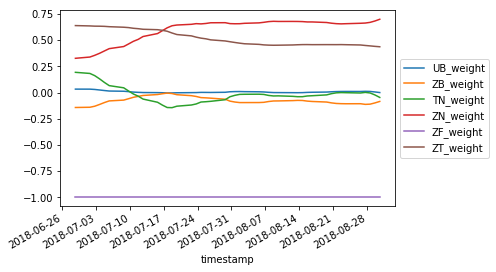

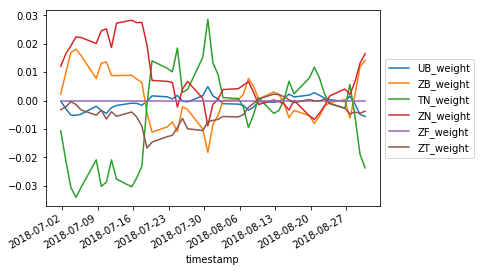

In [46]:
wp = train[weights].multiply(np.sign(train[weights].iloc[:,-1].values),axis=0)
#wp = train[weights].multiply(np.sign(train[weights].max(axis=1)).values,axis=0)
weights_daily = wp.iloc[::1380,]
weights_daily.plot()
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
weights_daily.diff().plot()
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))


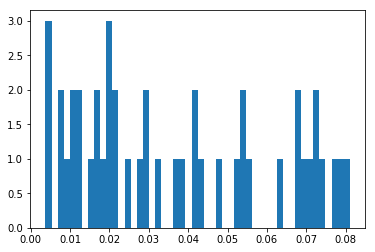

In [47]:
plt.hist(abs(weights_daily.diff().dropna()).sum(axis=1),bins=50)
plt.show()

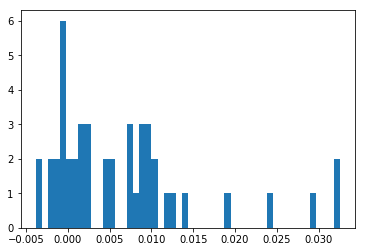

In [48]:
plt.hist(weights_daily.iloc[:,0],bins=50)
plt.show()

In [49]:
import seaborn as sns

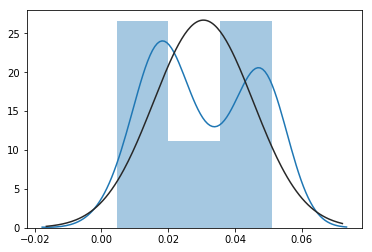

In [50]:
from scipy.stats import t
sns.distplot(weights_daily.dropna().sum(axis=1),fit=t)

In [51]:
t.fit(weights_daily.dropna().sum(axis=1))

(10258597.9674121, 0.030545542545872474, 0.014947277195367838)

# output the parameter txt

In [ ]:
weights

In [21]:
for row in train[::min_perday].iterrows():
    print(row)

(Timestamp('2018-06-21 17:00:00-0500', tz='US/Central'), UB8U               157859.375000
ZB8U               143921.875000
TN8U               127671.875000
ZN8U               119843.750000
ZF8U               113421.875000
ZT8U               211742.187500
UB8U_weight            -1.000000
ZB8U_weight            -2.650543
TN8U_weight            29.351809
ZN8U_weight           -44.484151
ZF8U_weight            21.107141
ZT8U_weight             1.907687
trading_idx             0.000000
portfolio          674871.743318
mu                 674544.855820
sigma                 429.414808
entry_threshold         7.155736
position                0.000000
l_position              0.000000
s_position              0.000000
trade                        NaN
Name: 2018-06-21 17:00:00-05:00, dtype: float64)
(Timestamp('2018-06-24 17:00:00-0500', tz='US/Central'), UB8U               158015.625000
ZB8U               144015.625000
TN8U               127710.937500
ZN8U               119859.375000
ZF8U        

In [19]:
for row in train[::min_perday].iterrows():
    date = (row[1].name.date())
    with open('{}.txt'.format(date),'w') as file:
        file.write('signal_mean={}\n'.format(row[1]['mu']))
        file.write('signal_standard_deviation={}\n'.format(row[1]['sigma']))
        file.write('entry_threshold={}\n'.format(row[1]['entry_threshold']))
        file.write('exit_threshold={}\n'.format(op_exit_threshold))
        row_weights = row[1][weights]
        for i in range(len(row_weights)):
            file.write('{}={}\n'.format(row_weights.index[i],row_weights[i]))

TypeError: Indexing a Series with DataFrame is not supported, use the appropriate DataFrame column

In [45]:
df.iloc[-2780:-2700]

,UB8U,ZB8U,TN8U,ZN8U,ZF8U,ZT8U
timestamp,,,,,,
2018-08-29 15:40:00-05:00,158.640625,144.546875,127.992188,120.054688,113.386719,105.714844
2018-08-29 15:41:00-05:00,158.640625,144.546875,127.992188,120.054688,113.386719,105.714844
2018-08-29 15:42:00-05:00,158.640625,144.546875,127.992188,120.054688,113.386719,105.714844
2018-08-29 15:43:00-05:00,158.671875,144.546875,127.992188,120.054688,113.386719,105.714844
2018-08-29 15:44:00-05:00,158.656250,144.546875,127.992188,120.070312,113.386719,105.714844
2018-08-29 15:45:00-05:00,158.640625,144.546875,127.992188,120.054688,113.386719,105.714844
2018-08-29 15:46:00-05:00,158.640625,144.546875,127.992188,120.054688,113.386719,105.714844
2018-08-29 15:47:00-05:00,158.671875,144.578125,127.992188,120.070312,113.386719,105.714844
2018-08-29 15:48:00-05:00,158.671875,144.578125,127.992188,120.070312,113.386719,105.714844
